# GSD: Rpb1 orthologs in PB genomes

This collects Rpb1 gene and protein sequences from a collection of PacBio sequenced yeast genomes from [Yue et al 2017](https://www.ncbi.nlm.nih.gov/pubmed/28416820), and then counts the heptad repeats. (Added in [SGD yeast nuclear reference genome](https://downloads.yeastgenome.org/sequence/S288C_reference/chromosomes/fasta/) as well even though PacBio set includes its own version of S288C.) It builds on the notebook [Searching for coding sequences in genomes using BLAST and Python](notebooks/Searching%20for%20coding%20sequences%20in%20genomes%20using%20BLAST%20and%20Python.ipynb) and use of PatMatch along with Python, the basics of which I illustrated [here](https://github.com/fomightez/patmatch-binder).

References for sequence data:  
- [Contrasting evolutionary genome dynamics between domesticated and wild yeasts.
Yue JX, Li J, Aigrain L, Hallin J, Persson K, Oliver K, Bergström A, Coupland P, Warringer J, Lagomarsino MC, Fischer G, Durbin R, Liti G. Nat Genet. 2017 Jun;49(6):913-924. doi: 10.1038/ng.3847. Epub 2017 Apr 17. PMID: 28416820](https://www.ncbi.nlm.nih.gov/pubmed/28416820)


- [Life with 6000 genes. Goffeau A, Barrell BG, Bussey H, Davis RW, Dujon B, Feldmann H, Galibert F, Hoheisel JD, Jacq C, Johnston M, Louis EJ, Mewes HW, Murakami Y, Philippsen P, Tettelin H, Oliver SG. Science. 1996 Oct 25;274(5287):546, 563-7. PMID: 8849441](https://www.ncbi.nlm.nih.gov/pubmed/8849441)
-----

## Preparation

Get scripts and sequence data necessary.

**DO NOT 'RUN ALL'. AN INTERACTION IS NECESSARY AT CELL FIVE. AFTER THAT INTERACTION, THE REST BELOW IT CAN BE RUN.**

(Caveat: right now this is written for genes with no introns. Only a few hundred have in yeast and that is the organism in this example. Intron presence would only become important when trying to translate in late stages of this workflow.)

In [1]:
gene_name = "RPB1"
size_expected = 5202
get_seq_from_link = False
link_to_FASTA_of_gene = "https://gist.githubusercontent.com/fomightez/f46b0624f1d8e3abb6ff908fc447e63b/raw/625eaba76bb54e16032f90c8812350441b753a0c/uz_S288C_YOR270C_VPH1_coding.fsa"
#**Possible future enhancement would be to add getting the FASTA of the gene from Yeastmine with just systematic id**

Get the genomes data, the `blast_to_df` script, and sequence to search for matches in the genomes by running these commands.

In [2]:
import os
file_needed = "blast_to_df.py"
if not os.path.isfile(file_needed):
    !curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/blast-utilities/blast_to_df.py
import pandas as pd
# Prepare for getting PacBio (Yue et al 2017 sequences)
#make a list of the strain designations
yue_et_al_strains = ["S288C","DBVPG6044","DBVPG6765","SK1","Y12",
                     "YPS128","UWOPS034614","CBS432","N44","YPS138",
                     "UFRJ50816","UWOPS919171"]
# Get & unpack the genome sequences from strains 
for s in yue_et_al_strains:
    !curl -LO http://yjx1217.github.io/Yeast_PacBio_2016/data/Nuclear_Genome/{s}.genome.fa.gz
    !gunzip -f {s}.genome.fa.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13759  100 13759    0     0  91726      0 --:--:-- --:--:-- --:--:-- 91119
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   2373      0 --:--:-- --:--:-- --:--:--  2373
100 3687k  100 3687k    0     0  13.4M      0 --:--:-- --:--:-- --:--:-- 13.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   6846      0 --:--:-- --:--:-- --:--:--  6846
100 3387k  100 3387k    0     0  17.1M      0 --:--:-- --:--:-- --:--:-- 17.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   To

In [3]:
# add identifiers to each `chr` so results for each strain clear later
chromosome_id_prefix = "chr"
def add_strain_id_to_description_line(file,strain_id):
    '''
    Takes a file and edits every description line to add 
    strain_id after the caret.
    
    Saves the fixed file
    '''
    import sys
    output_file_name = "temp.txt"
    # prepare output file for saving so it will be open and ready
    with open(output_file_name, 'w') as output_file:

        # read in the input file
        with open(file, 'r') as input_handler:
            # prepare to give feeback later or allow skipping to certain start
            lines_processed = 0

            for line in input_handler:
                lines_processed += 1
                if line.startswith(">"):
                    rest_o_line = line.split(">")
                    new_line = ">"+strain_id + rest_o_line[1]
                else:
                    new_line = line
                
                # Send text to output
                output_file.write(new_line)

    
    # replace the original file with edited
    !mv temp.txt {file}
    # Feedback
    sys.stderr.write("\n{} chromosome identifiers tagged.".format(file))

for s in yue_et_al_strains:
    add_strain_id_to_description_line(s+".genome.fa",s)


S288C.genome.fa chromosome identifiers tagged.
DBVPG6044.genome.fa chromosome identifiers tagged.
DBVPG6765.genome.fa chromosome identifiers tagged.
SK1.genome.fa chromosome identifiers tagged.
Y12.genome.fa chromosome identifiers tagged.
YPS128.genome.fa chromosome identifiers tagged.
UWOPS034614.genome.fa chromosome identifiers tagged.
CBS432.genome.fa chromosome identifiers tagged.
N44.genome.fa chromosome identifiers tagged.
YPS138.genome.fa chromosome identifiers tagged.
UFRJ50816.genome.fa chromosome identifiers tagged.
UWOPS919171.genome.fa chromosome identifiers tagged.

In [4]:
# Cannot simply use `S288C_reference_sequence_R64-2-1_20150113.fsa` at https://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/S288C_reference_genome_Current_Release.tgz
# because want nuclear only sequences here to match nuclear ones I obtaiend from 
# https://yjx1217.github.io/Yeast_PacBio_2016/data/, 
# where they keep nuclear and genome separate
chr_nums = ["01","02","03","04","05","06","07","08","09","10","11",
    "12","13","14","15","16"]
g_fns = []
for chr_num in chr_nums:
    fn = "chr"+chr_num+".fsa"
    !curl -OL https://downloads.yeastgenome.org/sequence/S288C_reference/chromosomes/fasta/{fn}
    g_fns.append(fn)
    # edit or replace description lines to work similar to PacBio
    tag = "SGD_REFchr"+chr_num+" "
    add_strain_id_to_description_line(fn,tag)
# zip all nuclear chromosomes together as one file as they are from https://yjx1217.github.io/Yeast_PacBio_2016/data/
!cat {" ".join(g_fns)} > SGD_REF.genome.fa
!rm chr*.fsa

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  228k  100  228k    0     0   374k      0 --:--:-- --:--:-- --:--:--  374k



chr01.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  807k  100  807k    0     0  1457k      0 --:--:-- --:--:-- --:--:-- 1457k



chr02.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  314k  100  314k    0     0   603k      0 --:--:-- --:--:-- --:--:--  602k



chr03.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1521k  100 1521k    0     0  2280k      0 --:--:-- --:--:-- --:--:-- 2277k



chr04.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  572k  100  572k    0     0  1051k      0 --:--:-- --:--:-- --:--:-- 1051k



chr05.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  268k  100  268k    0     0   547k      0 --:--:-- --:--:-- --:--:--  546k



chr06.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1083k  100 1083k    0     0  1767k      0 --:--:-- --:--:-- --:--:-- 1764k



chr07.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  558k  100  558k    0     0  1008k      0 --:--:-- --:--:-- --:--:-- 1008k



chr08.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  436k  100  436k    0     0   791k      0 --:--:-- --:--:-- --:--:--  789k



chr09.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  740k  100  740k    0     0  1339k      0 --:--:-- --:--:-- --:--:-- 1339k



chr10.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  662k  100  662k    0     0  1208k      0 --:--:-- --:--:-- --:--:-- 1208k



chr11.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1070k  100 1070k    0     0  1781k      0 --:--:-- --:--:-- --:--:-- 1778k



chr12.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  917k  100  917k    0     0  1502k      0 --:--:-- --:--:-- --:--:-- 1499k



chr13.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0  1345k      0 --:--:-- --:--:-- --:--:-- 1345k



chr14.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1083k  100 1083k    0     0  1730k      0 --:--:-- --:--:-- --:--:-- 1728k



chr15.fsa chromosome identifiers tagged.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  941k  100  941k    0     0  1191k      0 --:--:-- --:--:-- --:--:-- 1190k



chr16.fsa chromosome identifiers tagged.

In [5]:
# Get SGD gene sequence in FASTA format to search for best matches in the genomes
import sys
gene_filen = gene_name + ".fsa"
if get_seq_from_link:
    !curl -o {gene_filen} {link_to_FASTA_of_gene}
else:
    !touch {gene_filen}
    sys.stderr.write("\nEDIT THE FILE '{}' TO CONTAIN "
        "YOUR GENE OF INTEREST (FASTA-FORMATTED)"
        ".".format(gene_filen))
    sys.exit(0)


EDIT THE FILE 'RPB1.fsa' TO CONTAIN YOUR GENE OF INTEREST (FASTA-FORMATTED).

SystemExit: 0

/srv/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


**I PUT CONTENTS OF FILE `S288C_YDL140C_RPO21_coding.fsa` downloaded from [here](https://www.yeastgenome.org/locus/S000002299/sequence) as 'RPB1.fsa'.**

Now you are prepared to run BLAST to search each PacBio-sequenced genomes for the best match to a gene from the Saccharomyces cerevisiae strain S288C reference sequence.

## Use BLAST to search the genomes for matches to the gene in the reference genome at SGD

SGD is the [Saccharomyces cerevisiae Genome Database site](http:yeastgenome.org) and the reference genome is from S288C.

This is going to go through each genome and make a database so it is searchable and then search for matches to the gene. The information on the best match will be collected. One use for that information will be collecting the corresponding sequences later.

Import the script that allows sending BLAST output to Python dataframes so that we can use it here.

In [6]:
from blast_to_df import blast_to_df

In [7]:
# Make a list of all `genome.fa` files, excluding `genome.fa.nhr` and `genome.fa.nin` and `genome.fansq`
# The excluding was only necessary because I had run some queries preliminarily in development. Normally, it would just be the `.re.fa` at the outset.
fn_to_check = "genome.fa" 
genomes = []
import os
import fnmatch
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*'+fn_to_check):
        if not file.endswith(".nhr") and not file.endswith(".nin") and not file.endswith(".nsq") :
            genomes.append(file)
genomes

['DBVPG6044.genome.fa',
 'SGD_REF.genome.fa',
 'DBVPG6765.genome.fa',
 'CBS432.genome.fa',
 'YPS128.genome.fa',
 'UFRJ50816.genome.fa',
 'S288C.genome.fa',
 'SK1.genome.fa',
 'UWOPS034614.genome.fa',
 'UWOPS919171.genome.fa',
 'YPS138.genome.fa',
 'N44.genome.fa',
 'Y12.genome.fa']

In [8]:
SGD_gene = gene_filen
dfs = []
for genome in genomes:
    !makeblastdb -in {genome} -dbtype nucl
    result = !blastn -query {SGD_gene} -db {genome} -outfmt "6 qseqid sseqid stitle pident qcovs length mismatch gapopen qstart qend sstart send qframe sframe frames evalue bitscore qseq sseq"
    from blast_to_df import blast_to_df
    blast_df = blast_to_df(result.n)
    dfs.append(blast_df.head(1))



Building a new DB, current time: 01/04/2019 19:10:31
New DB name:   /home/jovyan/notebooks/GSD/DBVPG6044.genome.fa
New DB title:  DBVPG6044.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.14609 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:32
New DB name:   /home/jovyan/notebooks/GSD/SGD_REF.genome.fa
New DB title:  SGD_REF.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.137479 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:33
New DB name:   /home/jovyan/notebooks/GSD/DBVPG6765.genome.fa
New DB title:  DBVPG6765.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.120227 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:34
New DB name:   /home/jovyan/notebooks/GSD/CBS432.genome.fa
New DB title:  CBS432.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.173011 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:35
New DB name:   /home/jovyan/notebooks/GSD/YPS128.genome.fa
New DB title:  YPS128.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.117931 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:36
New DB name:   /home/jovyan/notebooks/GSD/UFRJ50816.genome.fa
New DB title:  UFRJ50816.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.155063 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:37
New DB name:   /home/jovyan/notebooks/GSD/S288C.genome.fa
New DB title:  S288C.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.16075 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:37
New DB name:   /home/jovyan/notebooks/GSD/SK1.genome.fa
New DB title:  SK1.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.117278 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:38
New DB name:   /home/jovyan/notebooks/GSD/UWOPS034614.genome.fa
New DB title:  UWOPS034614.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.129107 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:39
New DB name:   /home/jovyan/notebooks/GSD/UWOPS919171.genome.fa
New DB title:  UWOPS919171.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.117422 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:40
New DB name:   /home/jovyan/notebooks/GSD/YPS138.genome.fa
New DB title:  YPS138.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.387011 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:41
New DB name:   /home/jovyan/notebooks/GSD/N44.genome.fa
New DB title:  N44.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.116119 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.



Building a new DB, current time: 01/04/2019 19:10:42
New DB name:   /home/jovyan/notebooks/GSD/Y12.genome.fa
New DB title:  Y12.genome.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.12904 seconds.


Provided results read and converted to a dataframe...

A dataframe of the data has been saved as a file
in a manner where other Python programs can access it (pickled form).
RESULTING DATAFRAME is stored as ==> 'BLAST_pickled_df.pkl'

Returning a dataframe with the information as well.

In [9]:
# merge the dataframes in the list `dfs` into one dataframe
df = pd.concat(dfs)

In [10]:
#Save the df
filen_prefix = gene_name + "_orthologBLASTdf"
df.to_pickle(filen_prefix+".pkl")
df.to_csv(filen_prefix+'.tsv', sep='\t',index = False) 

In [11]:
df

,qseqid,sseqid,stitle,pident,qcovs,length,mismatch,gapopen,qstart,qend,sstart,send,qframe,sframe,frames,evalue,bitscore,qseq,sseq
0,RPO21,DBVPG6044chrIV,DBVPG6044chrIV,99.020,100,5202,30,11,1,5202,216501,211321,1,-1,1/-1,0.0,9304,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,SGD_REFchr04,SGD_REFchr04 tpg|BK006938.2| [organism=Sacchar...,100.000,100,5202,0,0,1,5202,210561,205360,1,-1,1/-1,0.0,9607,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,DBVPG6765chrIV,DBVPG6765chrIV,99.885,100,5202,6,0,1,5202,211477,206276,1,-1,1/-1,0.0,9574,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,CBS432chrIV,CBS432chrIV,92.522,100,5202,368,1,1,5202,211739,206559,1,-1,1/-1,0.0,7432,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGTCAACAGTATTCGAGTGCTCCACTCCGTACAGTGAAGG...
0,RPO21,YPS128chrIV,YPS128chrIV,99.923,100,5202,4,0,1,5202,210086,204885,1,-1,1/-1,0.0,9585,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,UFRJ50816chrXI,UFRJ50816chrXI,92.368,100,5202,355,9,1,5202,213091,207932,1,-1,1/-1,0.0,7369,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCGAGTGCTCCGCTCCGTACAGTGAAAG...
0,RPO21,S288CchrIV,S288CchrIV,100.000,100,5202,0,0,1,5202,210502,205301,1,-1,1/-1,0.0,9607,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,SK1chrIV,SK1chrIV,99.020,100,5202,30,11,1,5202,222692,217512,1,-1,1/-1,0.0,9304,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,UWOPS034614chrIV,UWOPS034614chrIV,99.500,100,5202,5,1,1,5202,209007,203827,1,-1,1/-1,0.0,9443,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...
0,RPO21,UWOPS919171chrIV,UWOPS919171chrIV,92.272,100,5202,402,0,1,5202,219693,214492,1,-1,1/-1,0.0,7380,ATGGTAGGACAACAGTATTCTAGTGCTCCACTCCGTACAGTAAAAG...,ATGGTAGGACAACAGTATTCGAGTGCTCCGCTCCGTACAGTGAAAG...


Computationally check if any genomes missing from the BLAST results list?

In [12]:
subjids = df.sseqid.tolist()
#print (subjids)
#print (subjids[0:10])
subjids = [x.split(chromosome_id_prefix)[0] for x in subjids]
#print (subjids)
#print (subjids[0:10])
len_genome_fn_end = len(fn_to_check) + 1 # plus one to accound for the period that will be 
# between `fn_to_check` and strain_id`, such as `SK1.genome.fa`
genome_ids = [x[:-len_genome_fn_end] for x in genomes]
#print (genome_ids[0:10])

a = set(genome_ids)
#print (a)
print ("initial:",len(a))
r = set(subjids)
print("results:",len(r))
print ("missing:",len(a-r))
#a - r

initial: 13
results: 13
missing: 0


Sanity check: Report on how expected size compares to max size seen?

In [13]:
size_seen = df.length.max(0)
print ("Expected size of gene:", size_expected)
print ("Most frequent size of matches:", df.length.mode()[0])
print ("Maximum size of matches:", df.length.max(0))

Expected size of gene: 5202
Most frequent size of matches: 5202
Maximum size of matches: 5202


## Collect the identified, raw sequences

Get the expected size centered on the best match, plus a little flanking each because they might not exactly cover the entire open reading frame. (Although, the example here all look to be full size.)

In [14]:
# Get the script for extracting based on position (and install dependency pyfaidx)
import os
file_needed = "extract_regions_from_clustal_alignment.py"
if not os.path.isfile(file_needed):
    !curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/Extract_from_FASTA/extract_subsequence_from_FASTA.py
!pip install pyfaidx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16612  100 16612    0     0  54465      0 --:--:-- --:--:-- --:--:-- 54465
  Running setup.py bdist_wheel for pyfaidx ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/54/a2/b4/e242e58d23b2808e191b214067880faa46cd2341f363886e0b
Successfully built pyfaidx


In [15]:
size_expected = size_expected # use value from above, or alter at this point.
#size_expected = df.length.max(0) #bp length of SGD coding sequence; should be equivalent and that way not hardcoded?
extra_add_to_start = 51 #to allow for 'fuzziness' at starting end
extra_add_to_end = 51 #to allow for 'fuzziness' at far end
genome_fn_end = "genome.fa" 


def midpoint(items):
    '''
    takes a iterable of items and returns the midpoint (integer) of the first 
    and second values
    '''
    return int((int(items[0])+int(items[1]))/2)

#midpoint((1,100))

def determine_pos_to_get(match_start,match_end):
    '''
    Take the start and end of the matched region.
    
    Calculate midpoint between those and then 
    center expected size on that to determine
    preliminary start and preliminary end to get.
    Add the extra basepairs to get at each end
    to allow for fuzziness/differences of actual
    gene ends for orthologs. 
    Return the final start and end positions to get.
    
    '''
    center_of_match = midpoint((match_start,match_end))
    half_size_expected = int(size_expected/2.0)
    if size_expected % 2 != 0:
        half_size_expected += 1
    start_pos = center_of_match - half_size_expected
    end_pos = center_of_match + half_size_expected
    start_pos -= extra_add_to_start
    end_pos += extra_add_to_end 
    
    # Because of getting some flanking sequences to account for 'fuzziness', it 
    # is possible the start and end can exceed possible. 'End' is not a problem 
    # because the `extract_subsequence_from_FASTA.py` script will get as much as
    # it from the indicated sequence if a larger than possible number is 
    # provided. However,'start' can become negative and because the region to 
    # extract is provided as a string the dash can become a problem. Dealing 
    # with it here by making sequence positive only.
    if start_pos < 0:
            start_pos = 1
        
    return start_pos, end_pos


# go through the dataframe using information on each to come up with sequence file, 
# specific indentifier within sequence file, and the start and end to extract
# store these valaues as a list in a dictionary with the strain identifier as the key.
extracted_info = {}
start,end = 0,0
for row in df.itertuples():
    #print (row.length)
    start_to_get, end_to_get = determine_pos_to_get(row.sstart, row.send)
    posns_to_get = "{}-{}".format(start_to_get, end_to_get)
    record_id = row.sseqid
    strain_id = row.sseqid.split(chromosome_id_prefix)[0]
    seq_fn = strain_id + "." + genome_fn_end
    extracted_info[strain_id] = [seq_fn, record_id, posns_to_get]
# Use the dictionary to get the sequences
for id_ in extracted_info:
    #%run extract_subsequence_from_FASTA.py {*extracted_info[id_]} #unpacking doesn't seem to work here in `%run`
    %run extract_subsequence_from_FASTA.py {extracted_info[id_][0]} {extracted_info[id_][1]} {extracted_info[id_][2]}

#package up the retrieved sequences
archive_file_name = gene_name+"_raw_ortholog_seqs.tar.gz"
# make list of extracted files using fnmatch
fn_part_to_match = "seq_extracted"
collected_seq_files_list = []
import os
import sys
import fnmatch
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, fn_part_to_match+'*'):
        #print (file)
        collected_seq_files_list.append(file)
!tar czf {archive_file_name} {" ".join(collected_seq_files_list)} # use the list for archiving command
sys.stderr.write("\n\nCollected RAW sequences gathered and saved as "
                 "`{}`.".format(archive_file_name))
# move the collected raw sequences to a folder in preparation for
# extracting encoding sequence from original source below
!mkdir raw
!mv seq_extracted*.fa raw



*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedDBVPG6044chrIV.fa'.
*****************DONE**************************


*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedSGD_REFchr04.fa'.
*****************DONE**************************


*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedDBVPG6765chrIV.fa'.
*****************DONE**************************


*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedCBS432chrIV.fa'.
*****************DONE**************************


*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedYPS128chrIV.fa'.
*****************DONE**************************


*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedUFRJ50816chrXI.fa'.


That archive should contain the "raw" sequence for each gene, even if the ends are a little different for each. At minimum the entire gene sequence needs to be there at this point; extra at each end is preferable at this point.

You should inspect them as soon as possible and adjust the extra sequence to add higher or lower depending on whether the ortholog genes vary more or less, respectively. The reason they don't need to be perfect yet though is because next we are going to extract the longest open reading frame, which presumably demarcates the entire gene. Then we can return to use that information to clean up the collected sequences to just be the coding sequence.

## Collect protein translations of the genes and then clean up "raw" sequences to just be coding

We'll assume the longest translatable frame in the collected "raw" sequences encodes the protein sequence for the gene orthologs of interest. Well base these steps on the [section '20.1.13  Identifying open reading frames'](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc299) in the present version of the [Biopython Tutorial and Cookbook](http://biopython.org/DIST/docs/tutorial/Tutorial.html) (Last Update – 18 December 2018 (Biopython 1.73).

(First run the next cell to get a script needed for dealing with the strand during the translation and gathering of thge encoding sequence.)

In [16]:
import os
file_needed = "convert_fasta_to_reverse_complement.py"
if not os.path.isfile(file_needed):
    !curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/ConvertSeq/convert_fasta_to_reverse_complement.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8851  100  8851    0     0  63676      0 --:--:-- --:--:-- --:--:-- 63676


Now to perform the work described in the header to this section...

In [17]:
# find the featured open reading frame and collect presumed protein sequences
# Collect the corresponding encoding sequence from the original source
def len_ORF(items):
    # orf is fourth item in the tuples
    return len(items[3])
def find_orfs_with_trans(seq, trans_table, min_protein_length):
    '''
    adapted from the present section '20.1.13  Identifying open reading frames'
    http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc299 in the 
    present version of the [Biopython Tutorial and Cookbook at 
    http://biopython.org/DIST/docs/tutorial/Tutorial.html 
    (Last Update – 18 December 2018 (Biopython 1.73)
    Same as there except altered to sort on the length of the
    open reading frame.
    '''
    answer = []
    seq_len = len(seq)
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        for frame in range(3):
            trans = str(nuc[frame:].translate(trans_table))
            trans_len = len(trans)
            aa_start = 0
            aa_end = 0
            while aa_start < trans_len:
                aa_end = trans.find("*", aa_start)
                if aa_end == -1:
                    aa_end = trans_len
                if aa_end-aa_start >= min_protein_length:
                    if strand == 1:
                        start = frame+aa_start*3
                        end = min(seq_len,frame+aa_end*3+3)
                    else:
                        start = seq_len-frame-aa_end*3-3
                        end = seq_len-frame-aa_start*3
                    answer.append((start, end, strand,
                                   trans[aa_start:aa_end]))
                aa_start = aa_end+1
    answer.sort(key=len_ORF, reverse = True)
    return answer

def generate_rcoutput_file_name(file_name,suffix_for_saving = "_rc"):
    '''
    from https://github.com/fomightez/sequencework/blob/master/ConvertSeq/convert_fasta_to_reverse_complement.py
    Takes a file name as an argument and returns string for the name of the
    output file. The generated name is based on the original file
    name.
    Specific example
    =================
    Calling function with
        ("sequence.fa", "_rc")
    returns
        "sequence_rc.fa"
    '''
    main_part_of_name, file_extension = os.path.splitext(
        file_name) #from 
    #http://stackoverflow.com/questions/541390/extracting-extension-from-filename-in-python
    if '.' in file_name:  #I don't know if this is needed with the os.path.splitext method but I had it before so left it
        return main_part_of_name + suffix_for_saving  + file_extension
    else:
        return file_name + suffix_for_saving + ".fa"
    
def add_strand_to_description_line(file,strand="-1"):
    '''
    Takes a file and edits description line to add 
    strand info at end.
    
    Saves the fixed file
    '''
    import sys
    output_file_name = "temp.txt"
    # prepare output file for saving so it will be open and ready
    with open(output_file_name, 'w') as output_file:

        # read in the input file
        with open(file, 'r') as input_handler:
            # prepare to give feeback later or allow skipping to certain start
            lines_processed = 0

            for line in input_handler:
                lines_processed += 1
                if line.startswith(">"):
                    new_line = line.strip() + "; {} strand\n".format(strand)
                else:
                    new_line = line
                
                # Send text to output
                output_file.write(new_line)

    
    # replace the original file with edited
    !mv temp.txt {file}
    # Feedback
    sys.stderr.write("\nIn {}, strand noted.".format(file))

table = 1 #sets translation table to standard nuclear, see 
# https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi
min_pro_len = 80 #cookbook had the standard `100`. Feel free to adjust.
prot_seqs_info = {} #collect as dictionary with strain_id as key. Values to
# be list with source id as first item and protein length as second and 
# strand in source seq as third item, and start and end in source sequence as fourth and fifth,
# and file name of protein and gene as sixth and seventh.
# Example key and value pair: 'YPS138':['<source id>','<protein length>',-1,52,2626,'<gene file name>','<protein file name>']
gene_seqs_fn_list = []
prot_seqs_fn_list = []
from Bio import SeqIO
for raw_seq_filen in collected_seq_files_list:
    #strain_id = raw_seq_filen[:-len_genome_fn_end] #if was dealing with source seq
    strain_id = raw_seq_filen.split(chromosome_id_prefix)[0].split("seq_extracted")[1]
    record = SeqIO.read("raw/"+raw_seq_filen,"fasta")
    raw_seq_source_fn = strain_id + "." + genome_fn_end
    raw_seq_source_id = record.description.split(":")[0]
    orf_list = find_orfs_with_trans(record.seq, table, min_pro_len)
    orf_start, orf_end, strand, prot_seq = orf_list[0] #longest ORF seq for protein coding
    
    location_raw_seq = record.description.rsplit(":",1)[1] #get to use in calculating
    # the start and end position in original genome sequence.
    raw_loc_parts = location_raw_seq.split("-")
    start_from_raw_seq = int(raw_loc_parts[0])
    end_from_raw_seq = int(raw_loc_parts[1])
    length_extracted = len(record) #also to use in calculating relative original
    
    # Trim back to the first Methionine, assumed to be the initiating MET.
    # (THIS MIGHT BE A SOURCE OF EXTRA 'LEADING' RESIDUES IN SOME CASES & ARGUES 
    # FOR LIMITING THE AMOUNT OF FLANKING SEQUENCE ADDED TO ALLOW FOR FUZINESS.)
    try:
        amt_resi_to_trim = prot_seq.index("M")
    except ValueError:
        sys.stderr.write("**ERROR**When searching for initiating methionine,\n"
                         "no Methionine found in the traslated protein sequence.**ERROR**")
        sys.exit(1)
    prot_seq = prot_seq[amt_resi_to_trim:]
    len_seq_trimmed = amt_resi_to_trim * 3
    
    # Calculate the adjusted start and end values for the untrimmed ORF
    adj_start = start_from_raw_seq + orf_start
    adj_end = end_from_raw_seq - (length_extracted - orf_end)
    
    # Adjust for trimming for appropriate strand.
    if strand == 1:
        adj_start += len_seq_trimmed
        #adj_end += 3 # turns out stop codon is part of numbering biopython returns
    elif strand == -1:
        adj_end -= len_seq_trimmed
        #adj_start -= 3 # turns out stop codon is part of numbering biopython returns
    else:
        sys.stderr.write("**ERROR**No strand match option detected!**ERROR**")
        sys.exit(1)
    
    # Collect the sequence for the actual gene encoding region from
    # the original sequence. This way the original numbers will
    # be put in the file.
    start_n_end_str = "{}-{}".format(adj_start,adj_end)
    %run extract_subsequence_from_FASTA.py {raw_seq_source_fn} {raw_seq_source_id} {start_n_end_str}
    
    # rename the extracted subsequence a more distinguishing name and notify
    g_output_file_name = strain_id +"_" + gene_name + "_ortholog_gene.fa"
    !mv {raw_seq_filen} {g_output_file_name} # because the sequence saved happens to 
    # be same as raw sequence file saved previously, that name can be used to
    # rename new file.
    gene_seqs_fn_list.append(g_output_file_name)
    sys.stderr.write("\n\nRenamed gene file to "
                     "`{}`.".format(g_output_file_name))
    
    # Convert extracted sequence to reverse complement if translation was on negative strand.
    if strand == -1:
        %run convert_fasta_to_reverse_complement.py {g_output_file_name}
        # replace original sequence file with the produced file
        produced_fn = generate_rcoutput_file_name(g_output_file_name)
        !mv {produced_fn} {g_output_file_name}
        # add (after saved) onto the end of the description line for that `-1 strand` 
        # No way to do this in my current version of convert sequence. So editing descr line.
        add_strand_to_description_line(g_output_file_name)

    
    #When settled on actual protein encoding sequence, fill out
    # description to use for saving the protein sequence.
    prot_descr =  (record.description.rsplit(":",1)[0]+ " "+ gene_name 
                   + "_ortholog"+ "| " +str(len(prot_seq)) + " aas | from " 
                   + raw_seq_source_id + " "
                   + str(adj_start) + "-"+str(adj_end))
    if strand == -1:
        prot_descr += "; {} strand".format(strand)
    
    # save the protein sequence as FASTA
    chunk_size = 70 #<---amino acids per line to have in FASTA
    prot_seq_chunks = [prot_seq[i:i+chunk_size] for i in range(
        0, len(prot_seq),chunk_size)]
    prot_seq_fa = ">" + prot_descr + "\n"+ "\n".join(prot_seq_chunks)
    p_output_file_name = strain_id +"_" + gene_name + "_protein_ortholog.fa"
    with open(p_output_file_name, 'w') as output:
        output.write(prot_seq_fa)
    prot_seqs_fn_list.append(p_output_file_name)
    sys.stderr.write("\n\nProtein sequence saved as "
                     "`{}`.".format(p_output_file_name))
    
    
    # at end store information in `prot_seqs_info` for later making a dataframe 
    # and then text table for saving summary
    #'YPS138':['<source id>',<protein length>,-1,52,2626,'<gene file name>','<protein file name>']
    prot_seqs_info[strain_id] = [raw_seq_source_id,len(prot_seq),strand,adj_start,adj_end,
                                 g_output_file_name,p_output_file_name]
    
    sys.stderr.write("\n******END OF A SET OF PROTEIN ORTHOLOG "
                     "AND ENCODING GENE********")

/srv/conda/lib/python3.6/site-packages/Bio/Seq.py:2576: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


*****************DONE**************************
Extracted sequence saved in FASTA format as 'seq_extractedDBVPG6044chrIV.fa'.
*****************DONE**************************


Renamed gene file to `DBVPG6044_RPB1_ortholog_gene.fa`.

*****************DONE**************************
Sequences in FASTA file 'DBVPG6044_RPB1_ortholog_gene.fa' converted to reverse complement
and saved as 'DBVPG6044_RPB1_ortholog_gene_rc.fa'.
*****************DONE**************************

In DBVPG6044_RPB1_ortholog_gene.fa, strand noted.

Protein sequence saved as `DBVPG6044_RPB1_protein_ortholog.fa`.
******END OF A SET OF PROTEIN ORTHOLOG AND ENCODING GENE********

*****************DONE**************************
Extracted sequence saved in FASTA format as 'se

In [18]:
# use `prot_seqs_info` for saving a summary text table (first convert to dataframe?)
table_fn_prefix = gene_name + "_orthologs_table"
table_fn = table_fn_prefix + ".tsv"
pkl_table_fn = table_fn_prefix + ".pkl"
import pandas as pd
info_df = pd.DataFrame.from_dict(prot_seqs_info, orient='index',
    columns=['descr_id', 'length', 'strand', 'start','end','gene_file','prot_file']) # based on
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_dict.html and
# note from Python 3.6 that `pd.DataFrame.from_items` is deprecated; 
#"Please use DataFrame.from_dict"
info_df.to_pickle(pkl_table_fn)
info_df.to_csv(table_fn, sep='\t') # keep index is default
sys.stderr.write("Text file of associated details saved as '{}'.".format(table_fn))

Text file of associated details saved as 'RPB1_orthologs_table.tsv'.

In [19]:
# pack up archive of gene and protein sequences plus the table
seqs_list = gene_seqs_fn_list + prot_seqs_fn_list + [table_fn,pkl_table_fn]
archive_file_name = gene_name+"_ortholog_seqs.tar.gz"
!tar czf {archive_file_name} {" ".join(seqs_list)} # use the list for archiving command
sys.stderr.write("\nCollected gene and protein sequences"
                 " (plus table of details) gathered and saved as "
                 "`{}`.".format(archive_file_name))


Collected gene and protein sequences (plus table of details) gathered and saved as `RPB1_ortholog_seqs.tar.gz`.

Save the tarballed archive to your local machine.

-----

## Count the heptad repeats

Make a table of the heptad repeats for each orthlogous protein sequence.

In [20]:
# get the 'patmatch results to dataframe' script
!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/patmatch-utilities/patmatch_results_to_df.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18722  100 18722    0     0   121k      0 --:--:-- --:--:-- --:--:--  121k


Using the trick of putting `%%capture` on first line from [here](https://stackoverflow.com/a/23692951/8508004) to suppress the output from `patmatch_results_to_df` function from filling up cell.

In [21]:
%%time
%%capture
# Go through each protein sequence file and look for matches to heptad pattern

# LATER POSSIBLE IMPROVEMENT. Translate pasted gene sequence and add SGD REF S228C as first in list `prot_seqs_fn_list`. Because 
# although this set of orthologs includes essentially S228C, other lists won't and best to have reference for comparing.


heptad_pattern = "[YF]SP[TG]SP[STAGN]" # will catch repats#2 through #26 of S288C according to Corden, 2013 PMID: 24040939

from patmatch_results_to_df import patmatch_results_to_df
sum_dfs = []
raw_dfs = []
for prot_seq_fn in prot_seqs_fn_list:
    !perl ../../patmatch_1.2/unjustify_fasta.pl {prot_seq_fn}
    output = !perl ../../patmatch_1.2/patmatch.pl -p {heptad_pattern} {prot_seq_fn}.prepared
    os.remove(os.path.join(prot_seq_fn+".prepared")) #delete file made for PatMatch
    raw_pm_df = patmatch_results_to_df(output.n, pattern=heptad_pattern, name="CTD_heptad")
    raw_pm_df.sort_values('hit_number', ascending=False, inplace=True)
    sum_dfs.append(raw_pm_df.groupby('FASTA_id').head(1))
    raw_dfs.append(raw_pm_df)
sum_pm_df = pd.concat(sum_dfs, ignore_index=True)
sum_pm_df.sort_values('hit_number', ascending=False, inplace=True)
sum_pm_df = sum_pm_df[['FASTA_id','hit_number']]
sum_pm_df = sum_pm_df.reset_index(drop=True)
raw_pm_df = pd.concat(raw_dfs, ignore_index=True)

CPU times: user 347 ms, sys: 173 ms, total: 520 ms
Wall time: 10.4 s


Because of use of `%%capture` to suppress output, need a separate cell to see results summary.

In [22]:
sum_pm_df

,FASTA_id,hit_number
0,S288CchrIV,25
1,DBVPG6765chrIV,25
2,YPS128chrIV,25
3,SGD_REFchr04,25
4,Y12chrIV,25
5,YPS138chrIV,24
6,UWOPS034614chrIV,24
7,CBS432chrIV,24
8,UWOPS919171chrIV,24
9,N44chrIV,24


I assume that '+ 2' should be added to the hit_number for each based on S288C according to [Corden, 2013](https://www.ncbi.nlm.nih.gov/pubmed/24040939); however, that is something that could be explored further.

Any patterns obvious relative species?

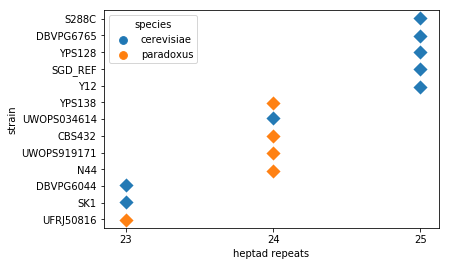

In [23]:
%matplotlib inline 
# above line works for JupyterLab which I was developing in. Try  `%matplotlib notebook` for when in classic.

# Visualization
# This is loosely based on my past use of seaborn when making `plot_sites_position_across_chromosome.py` and related scripts.
# For example, see `GC-clusters relative mito chromosome and feature` where I ran 
# `%run plot_sites_position_across_chromosome.py GC_df_for_merging.pkl -o strand_ofGCacross_mito_chrom`

# add the strain info for listing that without chr info & add species information for coloring on that
species_dict = {
    "SGD_REF":"cerevisiae",
    "S288C":"cerevisiae",
    "DBVPG6765":"cerevisiae",
    "Y12":"cerevisiae",
    "YPS128":"cerevisiae",
    "UWOPS034614":"cerevisiae",
    "CBS432":"paradoxus",
    "N44":"paradoxus",
    "YPS138":"paradoxus",
    "UWOPS919171":"paradoxus",
    "SK1":"cerevisiae",
    "DBVPG6044":"cerevisiae",
    "UFRJ50816":"paradoxus",
} # originally had keys ordered like https://www.nature.com/articles/ng.3847/figures/6 but adjusted
# when I wanted to control order of y-axis labels to have strains with most repeats at top; see 
# note below in `Adjusted look` mentioning not fond of essentially hardcoding; SGD_REF added
# later after style settled and so guarantee it would work with `Adjusted look`.
def FASTA_id_to_strain(FAid):
    '''
    use FASTA_id column value to convert to strain_id 
    and then return the strain_id
    '''
    return FAid.split(chromosome_id_prefix)[0]
sum_pm_df['strain'] = sum_pm_df['FASTA_id'].apply(FASTA_id_to_strain)
# sum_pm_df['species'] = sum_pm_df['FASTA_id'].apply(strain_to_species) # since need species for label plot strips
# it is easier to add species column first and then use map instead of doing both at same with one `apply`
# of a function or both separately, both with `apply` of two different function.
# sum_pm_df['species'] = sum_pm_df['strain'].apply(strain_to_species)
sum_pm_df['species'] = sum_pm_df['strain'].map(species_dict)

import seaborn as sns
# Simple look - Comment out everything below to the next two lines to see it again.
p = sns.stripplot(x="hit_number", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98)
p.set_xlabel("heptad repeats")
p.set_xticklabels([" ","23"," ","24", " ", "25"]) # This was much easier than all the stuff I tried for `Adjusted` look below
# and the only complaint I have with the results is that what I assume are the `minor` tick lines show up; still ended up
# needing this when added `xticks = p.xaxis.get_major_ticks()` in order to not show decimals for ones I kept
#p.set(xticks=[]) # this works to remove the ticks entirely; however, I want to keep major ticks
xticks = p.xaxis.get_major_ticks() #based on https://stackoverflow.com/q/50820043/8508004
for i in range(len(xticks)):
    #print (i) # WAS FOR DEBUGGING
    keep_ticks = [1,3,5] #harcoding essentially again, but at least it works
    if i not in keep_ticks:
        xticks[i].set_visible(False)

'''
# Highly Adjusted look - Comment out default look parts above. Ended up going with simple above because still couldn't get
# those with highest number of repeats with combination I could come up with.
sum_pm_df["repeats"] = sum_pm_df["hit_number"].astype(str) # when not here (use `x="hit_number"` in plot) or 
# tried `.astype('category')` get plotting of the 0.5 values too
sum_pm_df.sort_values('hit_number', ascending=True, inplace=True) #resorting again was necessary when
# added `sum_pm_df["hit_number"].astype(str)` to get 'lower' to 'higher' as left to right for x-axis; otherwise
# it was putting the first rows on the left, which happened to be the 'higher' repeat values
#p = sns.catplot(x="repeats", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98) #marker size ignored in catplot?
p = sns.stripplot(x="repeats", y="strain", hue="species", data=sum_pm_df, marker="D", size=10, alpha=.98)
#p = sns.stripplot(x="repeats", y="strain", hue="species", order = list(species_dict.keys()), data=sum_pm_df, marker="D", 
#    size=10, alpha=.98) # not fond of essentially harcoding to strain order but makes more logical sense to have
    # strains with most repeats at the top of the y-axis; adding `order` makes `sort` order be ignored
p.set_xlabel("heptad repeats")
sum_pm_df.sort_values('hit_number', ascending=False, inplace=True) #revert to descending sort for storing df;
''';

No obvious patterns except *cerevisiae* only one to reach the maximum seen among these cases. (Keep in mind that S288C is represented twice in all this.)

All the raw data is there for each strain in `raw_pm_df`. For example, the next cell shows how to view the data associated with the summary table for strain UFRJ50816:

In [24]:
UFRJ50816 = raw_pm_df[raw_pm_df['FASTA_id'] == 'UFRJ50816chrXI'].sort_values('hit_number', ascending=True).reset_index(drop=True)
UFRJ50816

,FASTA_id,hit_number,hit_id,start,end,strand,matching pattern,query pattern
0,UFRJ50816chrXI,1,CTD_heptad-1,1542,1548,1,FSPTSPT,[YF]SP[TG]SP[STAGN]
1,UFRJ50816chrXI,2,CTD_heptad-2,1549,1555,1,YSPTSPA,[YF]SP[TG]SP[STAGN]
2,UFRJ50816chrXI,3,CTD_heptad-3,1556,1562,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
3,UFRJ50816chrXI,4,CTD_heptad-4,1563,1569,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
4,UFRJ50816chrXI,5,CTD_heptad-5,1570,1576,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
5,UFRJ50816chrXI,6,CTD_heptad-6,1577,1583,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
6,UFRJ50816chrXI,7,CTD_heptad-7,1584,1590,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
7,UFRJ50816chrXI,8,CTD_heptad-8,1591,1597,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
8,UFRJ50816chrXI,9,CTD_heptad-9,1598,1604,1,YSPTSPS,[YF]SP[TG]SP[STAGN]
9,UFRJ50816chrXI,10,CTD_heptad-10,1605,1611,1,YSPTSPS,[YF]SP[TG]SP[STAGN]


The summary and raw data will be packaged up into one file in the cell below. One of the forms will be a tabular text data ('.tsv') files that can be opened in any spreadsheet software.

In [25]:
# save summary and raw results for use elsewhere (or use `.pkl` files for reloading the pickled dataframe into Python/pandas)
patmatch_fn_prefix = gene_name + "_orthologs_patmatch_results"
patmatchsum_fn_prefix = gene_name + "_orthologs_patmatch_results_summary"
patmatch_fn = patmatch_fn_prefix + ".tsv"
pkl_patmatch_fn = patmatch_fn_prefix + ".pkl"
patmatchsum_fn = patmatchsum_fn_prefix + ".tsv"
pklsum_patmatch_fn = patmatchsum_fn_prefix + ".pkl"
import pandas as pd
sum_pm_df.to_pickle(pklsum_patmatch_fn)
sum_pm_df.to_csv(patmatchsum_fn, sep='\t') # keep index is default
sys.stderr.write("Text file of summary details saved as '{}'.".format(patmatchsum_fn))
raw_pm_df.to_pickle(pkl_patmatch_fn)
raw_pm_df.to_csv(patmatch_fn, sep='\t') # keep index is default
sys.stderr.write("\nText file of raw details saved as '{}'.".format(patmatchsum_fn))
# pack up archive dataframes
pm_dfs_list = [patmatch_fn,pkl_patmatch_fn,patmatchsum_fn,pklsum_patmatch_fn]
archive_file_name = patmatch_fn_prefix+".tar.gz"
!tar czf {archive_file_name} {" ".join(pm_dfs_list)} # use the list for archiving command
sys.stderr.write("\nCollected pattern matching"
                 " results gathered and saved as "
                 "`{}`.".format(archive_file_name))

Text file of summary details saved as 'RPB1_orthologs_patmatch_results_summary.tsv'.
Text file of raw details saved as 'RPB1_orthologs_patmatch_results_summary.tsv'.
Collected pattern matching results gathered and saved as `RPB1_orthologs_patmatch_results.tar.gz`.

Download the tarballed archive of the files to your computer.

----